# Ballistic sedimentation tests

Notes from DA Kring 06/01/21

"The ballistic speed of ejected material traveling over distances that are small relative to the radius of a body can be estimated assuming a planar surface.  The ballistic speed (υ) is then

$υ = \sqrt{\frac{d g}{sin2\theta}}$

where d is the ballistic range, g is gravity (1.624 m/s2 for the Moon), θ is the ejection angle (typically 45°, used here).  The ballistic speed of ejected material traveling 28 to 40 km is 770 to 920 km/hr (0.21 to 0.25 km/s).  Such speeds are too low to produce an explosion or hypervelocity impact crater; typically 3 km/s is needed for the kinetic energy of impact to exceed the internal energy of the impactor, causing an explosive release of energy.  The material might, instead, fragment upon landing and produce a distributed series of rocks.  It might also mechanically excavate a crater, which is not observed.

When the distance is larger, a planar surface approximation is no longer appropriate.  To derive a ballistic formula for a spherical body, we begin with the half-angular distance of travel, φ = R/2Rp, which is related to velocity and the ejection angle (θ) by (Vickery, 1986)

$tan \phi = \frac{v^2 sin \theta cos \theta}{g R_p - v^2 cos^2 \theta}$

where g is again gravity and Rp the Moon’s radius, assuming it is a perfect sphere.  That can be rewritten as

$v = \sqrt{\frac{gR_p tan \phi}{sin \theta cos \theta + cos^2 \theta tan \phi}}$

We utilize an ejection angle of 45°, which is the most probable angle, and noting that the velocity is relatively insensitive to variations of 45 ± 15° (Vickery, 1986).  For Rp = 1737 km, the ballistic speed of debris traveling 400 to 435 km would be 0.76 to 0.79 km/s (2750 to 2860 km/hr).  Those are not hypervelocity speeds, but there would be sufficient kinetic energy to mechanically excavate craters upon landing."

In [138]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

# Constants
G_MOON = 1.624  # [m s^-2]
R_MOON = 1737 * 1e3  # [m]

# Functions
def ballistic_planar(theta, d, g=G_MOON):
    """
    Return ballistic speed (v) given ballistic range (d) and gravity of planet (g).
    
    Assumes planar surface (d << R_planet)
    """
    return np.sqrt((d * g) / np.sin(2 * theta))


def ballistic_spherical(theta, d, g=G_MOON, rp=R_MOON):
    """
    Return ballistic speed (v) given distance of travel (d) and gravity and radius of planet (g, Rp).
    
    Assumes perfectly spherical planet (Vickery, 1986).
    """
    tan_phi = np.tan(d / (2 * rp))
    return np.sqrt(
        (g * rp * tan_phi) / 
        ((np.sin(theta) * np.cos(theta)) + (np.cos(theta)**2 * tan_phi))
    )

def mps2kmph(v):
    """Return v in km/hr, given v in m/s"""
    return 3600. * v / 1000.

def thickness(d, R):
    """Calculate the thickness of an ejecta blanket in meters"""
    return 0.14 * (R**0.74) * ((d/R)**-3.)# pm 0.5

def thick2mass(thick):
    """
    Convert an ejecta blanket thickness to kg per meter squared
    
    Density from Carrier et al. 1991
    """
    return thick * 1500.

def mps2KE(v, m):
    """Convert ballistic speeds to kinetic energies in joules per meter squared"""
    return 0.5 * m * v**2.


In [203]:
Rad = pd.read_csv('cannon2020_crater_ages.csv',usecols=[3])#np.array([25.7, 25.9, 21.25, 28.85, 29.6, 16.35])*1000. #UPDATE
R = (Rad['Diam (km)']) * 1000. /2.
theta = np.deg2rad(45)
d = np.arange(10, 450) * 1000.  # [m]
thick = np.empty((len(R), len(d)))
v_planar = mps2kmph(ballistic_planar(theta, d))
v_spherical = mps2kmph(ballistic_spherical(theta, d))
for r in range(0,len(R)):
    thick[r, :] = thickness(np.linspace(1.*R[r],4.*R[r],len(d)), R[r])
ke = mps2KE(ballistic_spherical(theta, d), thick2mass(thick))

delT = 272. - 40. #heat from a temperature (here 40 K) to the melting point of water, 272 K
Cp = 4.2 #0.3 kJ/kg/K, heat capacity for regolith, 0.7 to 4.2 kJ/kg/K for H2O

Q = 0.056*0.2*ke / 1000. #kJ / m^2, 0.3-0.1 is the factor of heat not lost by radiation into space (Stopar 2018), 0.056 is the percentage of ice vs regolith (Colaprete2010)
L = 333. #latent heat of ice, kJ / kg
Mice = Q/(L + Cp*delT)


Planar examples:
Ballistic speed at distance 38 km: 894 km/h
Ballistic speed at distance 50 km: 1026 km/h

Spherical examples:
Ballistic speed at distance 410 km: 2784 km/h
Ballistic speed at distance 445 km: 2888 km/h


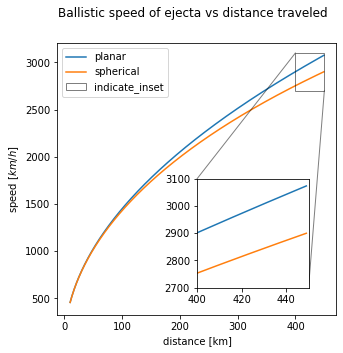

In [204]:
f, ax = plt.subplots(figsize=(5, 5))
f.suptitle('Ballistic speed of ejecta vs distance traveled')

d_km = d / 1000
ax.plot(d_km, v_planar, label='planar')
ax.plot(d_km, v_spherical, label='spherical')

# inset
axins = ax.inset_axes([0.5, 0.1, 0.4, 0.4])
axins.plot(d_km, v_planar, label='planar')
axins.plot(d_km, v_spherical, label='spherical')
x1, x2, y1, y2 = (400, 450, 2700, 3100)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="black")
ax.legend()

ax.set_xlabel('distance [km]')
ax.set_ylabel('speed [$km/h$]')
plt.savefig("speedvsdistance.png", dpi=300)

# Check values given to us
print('\nPlanar examples:')
for i in (28, 40):
    print(f'Ballistic speed at distance {d_km[i]:.0f} km: {v_planar[i]:.0f} km/h')

print('\nSpherical examples:')
for i in (400, 435):
    print(f'Ballistic speed at distance {d_km[i]:.0f} km: {v_spherical[i]:.0f} km/h')

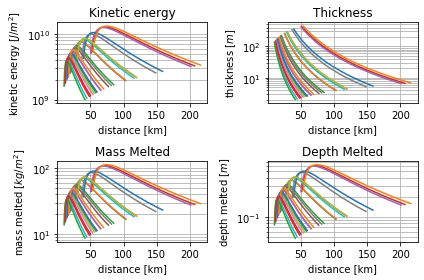

In [214]:
f2, axs = plt.subplots(2,2)#,figsize=(5, 5))
axs[0,0].set_title('Kinetic energy')
d_km = d / 1000
for i in range(0,len(R)):
    axs[0,0].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/1000., ke[i,:], label='Kinetic Energy')
axs[0,0].set_xlabel('distance [km]')
axs[0,0].set_ylabel('kinetic energy [$J/m^{2}$]')
axs[0,0].grid(True, which="both")

axs[0,1].set_title('Thickness')
for i in range(0,len(R)):
    axs[0,1].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/1000., thick[i,:], label='Thickness')
axs[0,1].set_xlabel('distance [km]')
axs[0,1].set_ylabel('thickness [$m$]')
axs[0,1].grid(True, which="both")

axs[1,0].set_title('Mass Melted')
for i in range(0,len(R)):
    axs[1,0].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/1000., Mice[i,:], label='Mass of ice melted per meter squared')
axs[1,0].set_xlabel('distance [km]')
axs[1,0].set_ylabel('mass melted [$kg / m^{2}$]')
axs[1,0].grid(True, which="both")

axs[1,1].set_title('Depth Melted')
for i in range(0,len(R)):
    axs[1,1].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/1000., Mice[i,:]/180., label='Depth of ice melted')
axs[1,1].set_xlabel('distance [km]')
axs[1,1].set_ylabel('depth melted [$m$]')
axs[1,1].grid(True, which="both")
plt.tight_layout()
plt.savefig("Distance_ejecta.png")

#f6, ax6 = plt.subplots(figsize=(5, 5))
#f6.suptitle('Ballistic speed of ejecta vs distance traveled')
#ax6.plot(d_km, v_spherical, label='Ballistic Speed')
#ax6.set_xlabel('distance [km]')
#ax6.set_ylabel('speed [$km/h$]')


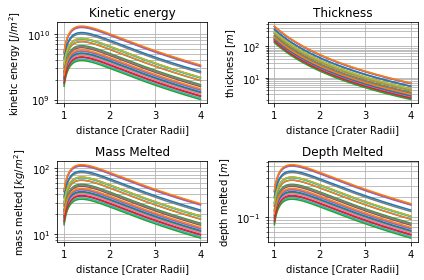

In [212]:
f3, axs = plt.subplots(2,2)#,figsize=(5, 5))
axs[0,0].set_title('Kinetic energy')

d_km = d / 1000
for i in range(0,len(R)):
    axs[0,0].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/R[i], ke[i,:], label='Kinetic Energy')
axs[0,0].set_xlabel('distance [Crater Radii]')
axs[0,0].set_ylabel('kinetic energy [$J/m^{2}$]')
axs[0,0].grid(True, which="both")

axs[0,1].set_title('Thickness')
for i in range(0,len(R)):
    axs[0,1].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/R[i], thick[i,:], label='Thickness')
axs[0,1].set_xlabel('distance [Crater Radii]')
axs[0,1].set_ylabel('thickness [$m$]')
axs[0,1].grid(True, which="both")

axs[1,0].set_title('Mass Melted')
for i in range(0,len(R)):
    axs[1,0].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/R[i], Mice[i,:], label='Mass of ice melted per meter squared')
axs[1,0].set_xlabel('distance [Crater Radii]')
axs[1,0].set_ylabel('mass melted [$kg / m^{2}$]')
axs[1,0].grid(True, which="both")

axs[1,1].set_title('Depth Melted')
for i in range(0,len(R)):
    axs[1,1].semilogy(np.linspace(1.*R[i],4.*R[i],len(d))/R[i], Mice[i,:]/180., label='Depth of ice melted')
axs[1,1].set_xlabel('distance [Crater Radii]')
axs[1,1].set_ylabel('depth melted [$m$]')
axs[1,1].grid(True, which="both")
plt.tight_layout()
plt.savefig("Distance_ejecta_R.png")